In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


### Read Data

In [2]:
calendar = pd.read_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\calendar.csv')
sales = pd.read_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\sales_train_validation.csv')
sell_price = pd.read_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\sell_prices.csv')

### Fill in the columns to be predicted
History data : d_1 ~ d_1913

Predict:

- Validation : d_1914 ~ d_1941
- Evaluation : d_1942 ~ d_1969

In [3]:
sales_fill_date = sales.copy()
date_list = []
for i in range(1914, 1970):
    date_list.append('d_'+str(i))
fill_date = pd.DataFrame(columns = date_list)
sales_fill_date = pd.concat([sales_fill_date, fill_date], axis = 1)
print(sales_fill_date)

                                  id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1960  d_1961  d_1962  \
0         CA_1       CA

### Select a group to predict

Demo
- cat_id : HOBBIES
- state_id : CA

In [4]:
df = sales_fill_date[(sales_fill_date['cat_id']=='HOBBIES') & (sales_fill_date['store_id']=='CA_1')]
df_melt = pd.melt(df, id_vars=df.columns[:6], value_vars=df.columns[6:])
df_melt.columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales']
df_all = pd.merge(df_melt, calendar, how = 'left')
df_all = pd.merge(df_all, sell_price, how = 'left')
print(df_all)

                                    id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4        HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
1112480  HOBBIES_2_145_CA_1_validation  HOBBIES_2_145  HOBBIES_2  HOBBIES   
1112481  HOBBIES_2_146_CA_1_validation  HOBBIES_2_146  HOBBIES_2  HOBBIES   
1112482  HOBBIES_2_147_CA_1_validation  HOBBIES_2_147  HOBBIES_2  HOBBIES   
1112483  HOBBIES_2_148_CA_1_validation  HOBBIES_2_148  HOBBIES_2  HOBBIES   
1112484  HOBBIES_2_149_CA_1_validation  HOBBIES_2_149  HOBBIES_2  HOBBIES   

        store_id state_id       d sales        date  wm_yr_wk  ... month  \

### Calculate the sum of each day

In [5]:
df_for_use = df_all[['d', 'sales']].groupby(['d']).sum().reset_index()
df_for_use['d'] = df_for_use['d'].str.replace('d_', '').astype('int')
df_for_use = df_for_use.sort_values(['d'])
print(df_for_use)

         d  sales
0        1    556
1081     2    498
1192     3    415
1303     4    392
1414     5    268
...    ...    ...
1073  1965      0
1074  1966      0
1075  1967      0
1076  1968      0
1077  1969      0

[1969 rows x 2 columns]


### Add Lag info

In [6]:
df_supervised = df_for_use.copy()
for inc in range(56,365):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['sales'].shift(inc)

df_supervised = df_supervised.dropna().reset_index(drop=True)
print(df_supervised)

         d  sales  lag_56  lag_57  lag_58  lag_59  lag_60  lag_61  lag_62  \
0      365    494   778.0   482.0   389.0   276.0   480.0   312.0   320.0   
1      366    411   551.0   778.0   482.0   389.0   276.0   480.0   312.0   
2      367    263   359.0   551.0   778.0   482.0   389.0   276.0   480.0   
3      368    329   310.0   359.0   551.0   778.0   482.0   389.0   276.0   
4      369    403   485.0   310.0   359.0   551.0   778.0   482.0   389.0   
...    ...    ...     ...     ...     ...     ...     ...     ...     ...   
1600  1965      0   363.0   495.0   542.0   655.0   722.0   401.0   429.0   
1601  1966      0   410.0   363.0   495.0   542.0   655.0   722.0   401.0   
1602  1967      0   527.0   410.0   363.0   495.0   542.0   655.0   722.0   
1603  1968      0   670.0   527.0   410.0   363.0   495.0   542.0   655.0   
1604  1969      0   714.0   670.0   527.0   410.0   363.0   495.0   542.0   

      lag_63  ...  lag_355  lag_356  lag_357  lag_358  lag_359  lag_360  \


### Split data

In [7]:
df_model = df_supervised.drop(['sales','d'],axis=1)
train_set, test_set = df_model[0:-84].values, df_model[-84:-56].values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### Build LSTM model

In [8]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0452
Epoch 2/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0336
Epoch 3/100
1521/1521 [==============================] - 2s 986us/step - loss: 0.0287
Epoch 4/100
1521/1521 [==============================] - 1s 975us/step - loss: 0.0250
Epoch 5/100
1521/1521 [==============================] - 2s 991us/step - loss: 0.0219
Epoch 6/100
1521/1521 [==============================] - 1s 984us/step - loss: 0.0192
Epoch 7/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0167
Epoch 8/100
1521/1521 [==============================] - 1s 981us/step - loss: 0.0144 1s - los - ETA: 0s - loss - ETA: 0s - 
Epoch 9/100
1521/1521 [==============================] - 1s 973us/step - loss: 0.0126
Epoch 10/100
1521/1521 [==============================] - 2s 988us/step - loss: 0.0111
Epoch 11/100
1521/1521 [==============================] - 1s 974us/step - loss: 0.0099 1s - l - ETA:
Epoch

1521/1521 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 96/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0011A: 0s - 
Epoch 97/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 98/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0012A: 0s - l
Epoch 99/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 100/100
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0011


### Prediction for test data

In [9]:
y_pred = model.predict(X_test,batch_size=1)
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
pred_test_set = []
for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

result_list = []
sales_dates = list(df_for_use[-84:-56].d)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0])
    result_dict['date'] = sales_dates[index]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
print(df_result)

    pred_value  date
0          555  1886
1          419  1887
2          353  1888
3          471  1889
4          509  1890
5          726  1891
6          653  1892
7          505  1893
8          468  1894
9          472  1895
10         381  1896
11         500  1897
12         535  1898
13         653  1899
14         579  1900
15         293  1901
16         569  1902
17         500  1903
18         580  1904
19         775  1905
20         726  1906
21         455  1907
22         358  1908
23         502  1909
24         434  1910
25         555  1911
26         645  1912
27         605  1913


### Plot performance of test set

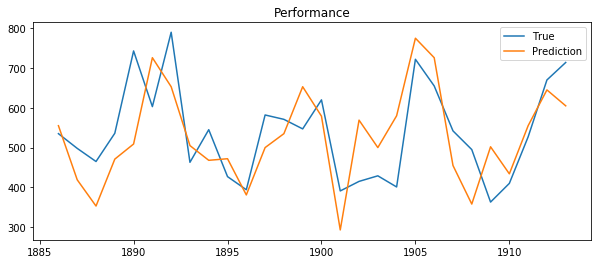

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df_for_use['d'][-84:-56], df_for_use['sales'][-84:-56], label = 'True')
ax.plot(df_result['date'], df_result['pred_value'], label = 'Prediction')
ax.set_title('Performance')
ax.legend()

### Predict all groups

Total: 30 models (3 categories * 10 stores)

Predict each product (each id) by using it's groups model.

Time: about 4 hours (for loop is not a good way )

Score: 3.459

In [ ]:
submission_colnames = ['id']
for i in range(1,29):
    submission_colnames.append('F'+str(i))
submission_all = pd.DataFrame(columns = submission_colnames)
for cat in sales_fill_date['cat_id'].unique():
    for store in sales_fill_date['store_id'].unique():
        df = sales_fill_date[(sales_fill_date['cat_id']==cat) & (sales_fill_date['store_id']==store)]
        df_melt = pd.melt(df, id_vars=df.columns[:6], value_vars=df.columns[6:])
        df_melt.columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales']
        df_all = pd.merge(df_melt, calendar, how = 'left')
        df_all = pd.merge(df_all, sell_price, how = 'left')
        
        df_for_use = df_all[['d', 'sales']].groupby(['d']).sum().reset_index()
        df_for_use['d'] = df_for_use['d'].str.replace('d_', '').astype('int')
        df_for_use = df_for_use.sort_values(['d'])

        df_supervised = df_for_use.copy()
        for inc in range(56,365):
            field_name = 'lag_' + str(inc)
            df_supervised[field_name] = df_supervised['sales'].shift(inc)
        df_supervised = df_supervised.dropna().reset_index(drop=True)

        df_model = df_supervised.drop(['sales','d'],axis=1)
        train_set = df_model[0:-56].values
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler = scaler.fit(train_set)
        
        train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
        train_set_scaled = scaler.transform(train_set)
        
        X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        
        model = Sequential()
        model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)
        
        for ID in df_melt['id'].unique():
            val = df_melt[df_melt['id']==ID][['id', 'd', 'sales']].copy().reset_index(drop = True)
            val['d'] = val['d'].str.replace('d_', '').astype('int')
            val = val.sort_values(['d'])
            val = val.fillna(0)
            for inc in range(56,365):
                field_name = 'lag_' + str(inc)
                val[field_name] = val['sales'].shift(inc)
            val = val.dropna().reset_index(drop=True)
            val = val.drop(['id', 'sales','d'],axis=1)
            val = val[-56:].values
        
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler = scaler.fit(val)
            
            val = val.reshape(val.shape[0], val.shape[1])
            val_scaled = scaler.transform(val)
            X_val = val_scaled[:, 1:]
            X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
            
            lstm_pred = model.predict(X_val,batch_size=1)
            lstm_pred = lstm_pred.reshape(lstm_pred.shape[0], 1, lstm_pred.shape[1])
            val_pred_set = []
            for index in range(0,len(lstm_pred)):
                val_pred_set.append(np.concatenate([lstm_pred[index],X_val[index]],axis=1))
            val_pred_set = np.array(val_pred_set)
            val_pred_set = val_pred_set.reshape(val_pred_set.shape[0], val_pred_set.shape[2])
            val_pred_set_inverted = scaler.inverse_transform(val_pred_set)
            
            result_list = []
            sales_dates = list(df_for_use[-56:].d)
            for index in range(0,len(val_pred_set_inverted)):
                result_dict = {}
                result_dict['pred_value'] = int(val_pred_set_inverted[index][0])
                result_dict['date'] = sales_dates[index]
                result_list.append(result_dict)
            df_result = pd.DataFrame(result_list)
        
            final_val = np.transpose(pd.DataFrame([ID] + list(df_result['pred_value'].iloc[0:28,])))
            final_eval = np.transpose(pd.DataFrame([ID] + list(df_result['pred_value'].iloc[28:,])))

            final_val.columns = submission_colnames
            final_eval.columns = submission_colnames
            
            final_eval['id'] = final_eval['id'].str.replace('validation', 'evaluation')
            
            submission = pd.concat([final_val, final_eval], axis = 0).reset_index(drop = True)
        
            submission_all = pd.concat([submission_all, submission], axis = 0)
                
submission_all.to_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\submission_lstm2.csv', index = False)    
